In [1]:
# Setting seed for reproducibility
import os

seed = 5102
os.environ["PYTHONHASHSEED"] = str(seed)

import math
import random as rn
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input
from keras.callbacks import EarlyStopping
from keras.layers import (
    GRU,
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    LeakyReLU,
    MaxPooling1D,
    Reshape,
    TimeDistributed,
)
from keras.models import Sequential
from matplotlib.dates import DateFormatter
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras

# Setting seed for reproducibility (part 2)
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Data ingestion

In [2]:
# read training data
df = pd.read_csv("Data/final_data.csv")
DATE = df["Date"]
df.drop(columns="Date", inplace=True)
df

,Price_eth,addresses_active_count_onchain,RevUSD_market,Vader_Comp,Vol._futures,Vader_Neu,bids_market,supply_miner_held_by_all_addresses_within_one_hop_of_a_mining_entity_native_units_onchain,volatility_market,AdrActCnt_market,...,estimated_transaction_volume_usd_onchain,bidAskSpread_market,hash_rate_mean_onchain,HashRate_market,TxCnt_market,VtyDayRet30d_market,supply_held_by_top_100_addresses_onchain,Vader_Neg,target,test
0,1099.52,1230529,55986515.21,0.20215,8150.0,0.854741,2.696802e+07,2822587.597,186.406136,1040203.0,...,6.775408e+09,0.599972,145160753.6,1.582156e+08,260173.0,0.034317,2481892.551,0.039323,1.612101,False
1,1207.77,1344921,34231235.25,0.20215,19470.0,0.854741,3.261763e+07,2822077.477,184.314315,914351.0,...,7.549977e+09,0.583837,163652569.0,1.485729e+08,231423.0,0.054134,2474776.497,0.039323,1.535109,False
2,1224.35,1292297,22532356.46,0.20215,16830.0,0.854741,3.224854e+07,2821826.388,217.307109,817115.0,...,9.896770e+09,0.643784,155331252.4,9.512298e+07,232056.0,0.051059,2486440.508,0.039323,0.661790,False
3,1215.73,1237271,38861905.57,0.20215,15380.0,0.854741,3.492305e+07,2822390.243,265.300557,695892.0,...,8.838844e+09,0.682708,136839436.2,1.109758e+08,190234.0,0.030858,2501364.372,0.039323,-2.878639,False
4,1091.47,1211948,57409115.37,0.20215,22210.0,0.854741,3.533249e+07,2821437.198,434.242095,1053426.0,...,6.926937e+09,0.975458,157757649.3,1.593504e+08,289324.0,0.030561,2506447.879,0.039323,-0.828492,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1645.82,968985,24045257.30,0.20215,10310.0,0.854741,3.612133e+07,2535681.337,40.577728,968985.0,...,3.250991e+09,7.179025,398153805.9,3.981538e+08,433684.0,0.021518,2861831.938,0.039323,-0.188931,True
668,1629.00,1051172,16511404.94,0.20215,6920.0,0.854741,4.695970e+07,2540456.775,34.591558,981056.0,...,3.524506e+09,7.182452,417508504.3,2.576097e+08,286289.0,0.014097,2868529.984,0.039323,-0.035084,True
669,1634.46,940913,38214791.46,0.20215,4760.0,0.854741,5.251132e+07,2531580.566,18.351362,772112.0,...,2.284752e+09,7.174868,342854665.7,3.603416e+08,592036.0,0.023862,2865732.583,0.039323,-0.059476,True
670,1633.18,1001123,29899213.71,0.20215,5240.0,0.854741,5.297339e+07,2532717.983,25.093918,1020140.0,...,2.224002e+09,7.167681,364053703.3,4.304215e+08,387748.0,0.020988,2859586.844,0.039323,0.606220,True


# Data Preprocessing

In [3]:
def process_data(data, lb, features, target):
    features = keep_features(data, cols=features)
    target = data[target]
    X, y = [], []
    for i in range(len(data) - lb - 1):
        X.append(features[i : (i + lb)])
        y.append(target[(i + lb)])
    return np.array(X), np.array(y)


def keep_features(data, cols=[], selector=None):
    if not cols and selector is None:
        raise TypeError("Provide cols or selector function")
    if cols:
        return data[cols]
    return data[[c for c in data.columns if selector(c)]]


def unfold_standardize_fold(train_data, test_data, scaler=StandardScaler):
    # get shape info
    train_len, num_time_steps, num_features = train_data.shape
    test_len = test_data.shape[0]

    # unfold
    train_data = np.reshape(train_data, newshape=(-1, num_features))
    test_data = np.reshape(test_data, newshape=(-1, num_features))

    # standardize
    sc = scaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)

    # fold
    train_data = np.reshape(
        train_data, newshape=(train_len, num_time_steps, num_features)
    )
    test_data = np.reshape(test_data, newshape=(test_len, num_time_steps, num_features))

    return train_data, test_data

In [4]:
# Slice training and test data
train_df = df[df["test"] == False]
test_df = df[df["test"] == True].reset_index()

FEATURES = list(df.columns)[:-2]
NUM_FEATURES = len(FEATURES)
TARGET = list(df.columns)[-2]

# Number of days to include in each set of training data
LOOKBACK = 1
EPOCHS = 300
BATCH_SIZE = 32

# Perform data processing to get train test X and y
X_train, y_train = process_data(train_df, lb=LOOKBACK, features=FEATURES, target=TARGET)
X_test, y_test = process_data(test_df, lb=LOOKBACK, features=FEATURES, target=TARGET)
X_train, X_test = unfold_standardize_fold(X_train, X_test, scaler=StandardScaler)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((535, 1, 29), (133, 1, 29), (535,), (133,))

# LSTM

In [5]:
# Model Building
tf.keras.utils.set_random_seed(seed)
model_lstm = Sequential()

model_lstm.add(
    LSTM(
        512, input_shape=(LOOKBACK, NUM_FEATURES), return_sequences=True, name="LSTM_1"
    )
)
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32, name="LSTM_2", return_sequences=False))
# model_lstm.add(LeakyReLU(alpha=0.3))
# model.add(TimeDistributed(Dense(NUM_FEATURES)))
model_lstm.add(Dense(1, name="Dense_1"))

# compile model and print summary
model_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")],
)
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 1, 512)            1110016   
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 LSTM_2 (LSTM)               (None, 32)                69760     
                                                                 
 Dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1179809 (4.50 MB)
Trainable params: 1179809 (4.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [6]:
model_lstm.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    shuffle=False,
    verbose=1,
    callbacks=EarlyStopping(monitor="val_loss", patience=50),
)

Epoch 1/300
16/16 [==============================] - 4s 60ms/step - loss: 1.1548 - rmse: 1.0746 - val_loss: 0.1048 - val_rmse: 0.3237
Epoch 2/300
16/16 [==============================] - 0s 14ms/step - loss: 1.0885 - rmse: 1.0433 - val_loss: 0.1238 - val_rmse: 0.3518
Epoch 3/300
16/16 [==============================] - 0s 14ms/step - loss: 1.0270 - rmse: 1.0134 - val_loss: 0.1164 - val_rmse: 0.3412
Epoch 4/300
16/16 [==============================] - 0s 14ms/step - loss: 1.0605 - rmse: 1.0298 - val_loss: 0.1061 - val_rmse: 0.3257
Epoch 5/300
16/16 [==============================] - 0s 14ms/step - loss: 1.0003 - rmse: 1.0002 - val_loss: 0.1087 - val_rmse: 0.3298
Epoch 6/300
16/16 [==============================] - 0s 14ms/step - loss: 0.9134 - rmse: 0.9557 - val_loss: 0.1114 - val_rmse: 0.3338
Epoch 7/300
16/16 [==============================] - 0s 14ms/step - loss: 0.9814 - rmse: 0.9907 - val_loss: 0.1077 - val_rmse: 0.3282
Epoch 8/300
16/16 [==============================] - 0s 16ms/s

17/17 [==============================] - 0s 3ms/step


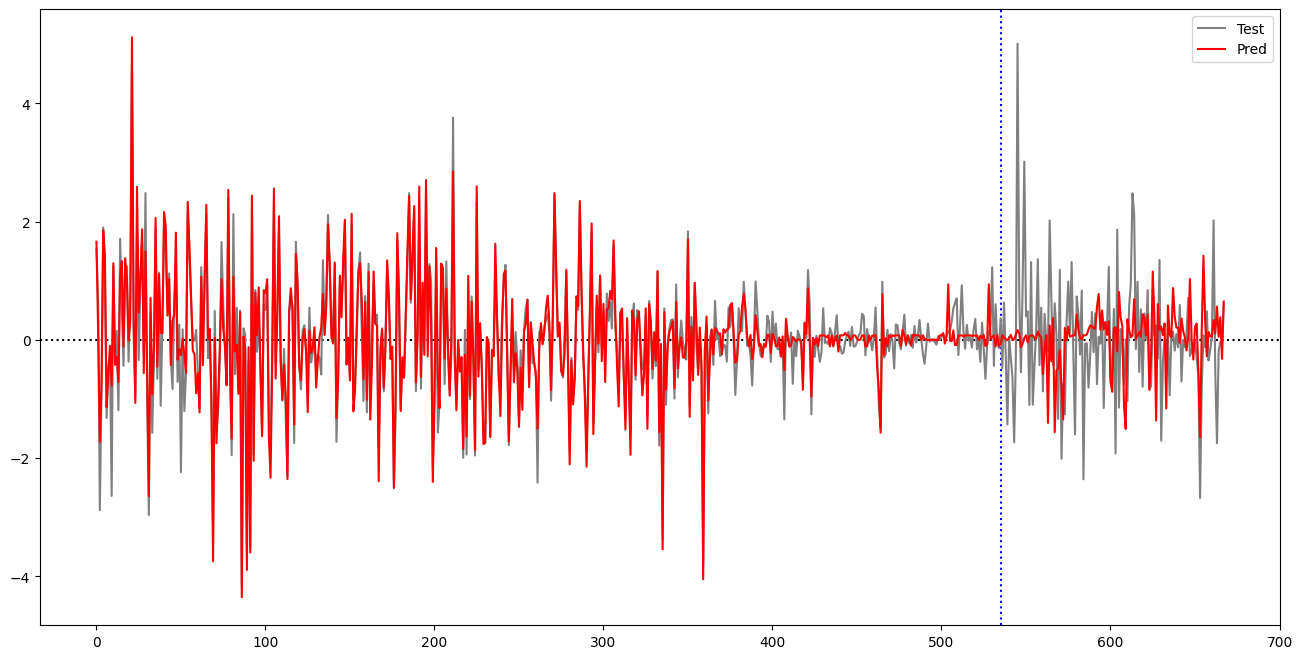

In [7]:
y_pred = model_lstm.predict(X_test)
y_train_pred = model_lstm.predict(X_train)
plt.figure(figsize=(16, 8))
plt.axvline(x=len(y_train), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linestyle=":")
plt.plot(np.concatenate([y_train, y_test]), color="grey", label="Test")
plt.plot(np.concatenate([y_train_pred, y_pred]), color="red", label="Pred")
plt.legend()
plt.show()

In [8]:
# calculate Test RMSE
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred, squared=False)

1.042870998790331